# EDA for classifying player position

In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

## Contents

* [Positional Rating Analysis](#Positional-Rating-Analysis)
* [Player Position Analysis](#Player-position)
* [Generalize player positions](#Generalize-player-positions)
* [Skills-GoalKeeping](#Skills-GoalKeeping)
* [Body Type](#body_type)
* [Work Rate](#work_rate)
* [Player Tags](#player_tags)
* [Player Traits](#player_traits)
* [Preferred Foot](#preferred_foot)
* [Club Analysis](#Club)

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OrdinalEncoder

from collections import defaultdict
import math

%matplotlib inline

#pd.set_option('display.width', 500)
#pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 110)

Original raw data downloaded from:

https://www.kaggle.com/stefanoleone992/fifa-20-complete-player-dataset


Glossary:

https://www.console-deals.com/blog/fifa-terminology-glossary-5504/

Player positions:
- CAM - Central attacking midfielder
- CB - Centre back
- CDM - Central defensive midfielder
- CF - Center forward
- CM - Centre midfielder
- GK - Goalkeeper
- LB - Left back
- LM - Left midfielder
- LW - Left winger (typically more attack-minded than a left midfielder)
- RB - Right back
- RM - Right midfielder
- RW - Right winger (a more attacking option than a right midfielder)
- ST - Striker


REAL OVERALL RATING - 
Seems to be a per-position adjustment based on the player's international reputation (IR). Some say that the number of stars can grant a +/-.
Possibly the OVR + IR

https://fifaforums.easports.com/en/discussion/82695/lack-of-team-management
Please read "Real Overall Rating" in sofifa
Different ability is needed in each position.
So Every position have different overall caculating.
This is already used in the game internally.
But Caculated overall is not displayed in Team Management.
Overall is always same in every positon.
This must be improved.

At each field layer left, right, and central positions are highly corelated.


### Constants

In [3]:
PLAYER_POSITION = []

In [4]:
TEST_SET_CLUBS = [
    'FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 
    'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United' ]

# From the problem statement, the following variables cannot be used
NOT_TO_BE_USED_COLS = ["sofifa_id", "player_url", "short_name", "long_name", "real_face", "wage_eur" ]

# Additional list of variables not needed
UNNEEDED_FEATURE_COLS = ["dob", "nationality", "nation_jersey_number", "loaned_from" ]
# TODO the cleaned data has 'Unnamed: 0' column

RESPONSE_COL = ["team_position"]

In [5]:
REAL_OVERALL_RATING_COLS = [ 
    'ls', 'st', 'rs',                     # strikers
    'lw', 'lf', 'cf', 'rf','rw',          # forwards
    'lam', 'cam', 'ram',                  # attacking midfielders
    'lm', 'lcm', 'cm', 'rcm', 'rm',       # midfielders
    'lwb', 'ldm','cdm','rdm','rwb',       # wingers
    'lb','lcb','cb','rcb','rb',           # backs
]

GK_SKILLS_COLS = [
    'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning'
]

# TODO there is no single gk predictor  
# 'gk'                                  # goal keeper


In [6]:
DATA_DIR_CLEANED = 'cleaned_data/'
DATA_DIR_RAW = 'data/'


###  Examine the raw data

In [7]:
df_raw = pd.read_csv(DATA_DIR_RAW+'players_19.csv')
df_raw.head()

sofifa_id                                         player_url  \
0      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
1     158023  https://sofifa.com/player/158023/lionel-messi/...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
3     193080  https://sofifa.com/player/193080/david-de-gea-...   
4     192985  https://sofifa.com/player/192985/kevin-de-bruy...   

          short_name                            long_name  age         dob  \
0  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   33  1985-02-05   
1           L. Messi       Lionel Andrés Messi Cuccittini   31  1987-06-24   
2          Neymar Jr        Neymar da Silva Santos Junior   26  1992-02-05   
3             De Gea                David De Gea Quintana   27  1990-11-07   
4       K. De Bruyne                      Kevin De Bruyne   27  1991-06-28   

   height_cm  weight_kg nationality                 club  overall  potential  \
0        187         83    Portugal             Juventus       94         94   
1        170         72   Argentina         FC Barcelona       94         94   
2        175         68      Brazil  Paris Saint-Germain       92         93   
3        193         76       Spain    Manchester United       91         93   
4        181         70     Belgium      Manchester City       91         92   

   value_eur  wage_eur player_positions preferred_foot  \
0   77000000    405000           ST, LW          Right   
1  110500000    565000       CF, RW, ST           Left   
2  118500000    290000          LW, CAM          Right   
3   72000000    260000               GK          Right   
4  102000000    355000          CAM, CM          Right   

   international_reputation  weak_foot  skill_moves      work_rate  \
0                         5          4            5       High/Low   
1                         5          4            4  Medium/Medium   
2                         5          5            5    High/Medium   
3                         4          3            1  Medium/Medium   
4                         4          5            4      High/High   

    body_type real_face  release_clause_eur  \
0  C. Ronaldo       Yes         127100000.0   
1       Messi       Yes         226500000.0   
2      Neymar       Yes         228100000.0   
3        Lean       Yes         138600000.0   
4      Normal       Yes         196400000.0   

                                         player_tags team_position  \
0  #Speedster, #Dribbler, #Distance Shooter, #Acr...            LW   
1  #Dribbler, #Distance Shooter, #FK Specialist, ...            RW   
2  #Speedster, #Dribbler, #FK Specialist, #Acroba...           CAM   
3                                                NaN            GK   
4  #Dribbler, #Playmaker  , #Engine, #Distance Sh...           RCM   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                 7.0         NaN  2018-07-10                2022.0   
1                10.0         NaN  2004-07-01                2021.0   
2                10.0         NaN  2017-08-03                2022.0   
3                 1.0         NaN  2011-07-01                2019.0   
4                17.0         NaN  2015-08-30                2023.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0              LS                   7.0  90.0      93.0     81.0       89.0   
1              CF                  10.0  88.0      91.0     88.0       96.0   
2              LW                  10.0  92.0      84.0     83.0       95.0   
3              GK                   1.0   NaN       NaN      NaN        NaN   
4             RCM                   7.0  77.0      86.0     92.0       87.0   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       35.0    79.0        NaN          NaN         NaN          NaN   
1       32.0    61.0        NaN          NaN         NaN          NaN   
2       32.0    59.0        NaN          NaN         Na

In [8]:
for i, c in enumerate(df_raw.columns):
    print(f"{i:4d}\t{c}")

   0	sofifa_id
   1	player_url
   2	short_name
   3	long_name
   4	age
   5	dob
   6	height_cm
   7	weight_kg
   8	nationality
   9	club
  10	overall
  11	potential
  12	value_eur
  13	wage_eur
  14	player_positions
  15	preferred_foot
  16	international_reputation
  17	weak_foot
  18	skill_moves
  19	work_rate
  20	body_type
  21	real_face
  22	release_clause_eur
  23	player_tags
  24	team_position
  25	team_jersey_number
  26	loaned_from
  27	joined
  28	contract_valid_until
  29	nation_position
  30	nation_jersey_number
  31	pace
  32	shooting
  33	passing
  34	dribbling
  35	defending
  36	physic
  37	gk_diving
  38	gk_handling
  39	gk_kicking
  40	gk_reflexes
  41	gk_speed
  42	gk_positioning
  43	player_traits
  44	attacking_crossing
  45	attacking_finishing
  46	attacking_heading_accuracy
  47	attacking_short_passing
  48	attacking_volleys
  49	skill_dribbling
  50	skill_curve
  51	skill_fk_accuracy
  52	skill_long_passing
  53	skill_ball_control
  54	movement_acceleration
  55	

#### Inspect the data types

In [9]:

df_raw.dtypes

sofifa_id      int64
player_url    object
short_name    object
long_name     object
age            int64
               ...  
lb            object
lcb           object
cb            object
rcb           object
rb            object
Length: 104, dtype: object

#### Inspect some individual records

In [10]:
# Take a look at a single player
df_raw[ df_raw['sofifa_id'] == 224458]

sofifa_id                                         player_url  short_name  \
721     224458  https://sofifa.com/player/224458/diogo-jose-te...  Diogo Jota   

                        long_name  age         dob  height_cm  weight_kg  \
721  Diogo José Teixeira da Silva   21  1996-12-04        178         73   

    nationality                     club  overall  potential  value_eur  \
721    Portugal  Wolverhampton Wanderers       78         86   15500000   

     wage_eur player_positions preferred_foot  international_reputation  \
721     56000           LW, ST          Right                         2   

     weak_foot  skill_moves  work_rate body_type real_face  \
721          4            4  High/High      Lean        No   

     release_clause_eur player_tags team_position  team_jersey_number  \
721          32600000.0    #Acrobat            LW                18.0   

    loaned_from      joined  contract_valid_until nation_position  \
721         NaN  2018-07-01                2021.0             NaN   

     nation_jersey_number  pace  shooting  passing  dribbling  defending  \
721                   NaN  82.0      74.0     69.0       82.0       51.0   

     physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  \
721    76.0        NaN          NaN         NaN          NaN       NaN   

     gk_positioning                              player_traits  \
721             NaN  Injury Free, Speed Dribbler (CPU AI Only)   

    attacking_crossing attacking_finishing attacking_heading_accuracy  \
721                 65                  74                       56-2   

    attacking_short_passing attacking_volleys skill_dribbling  ...  \
721                      73                71              81  ...   

    movement_acceleration movement_sprint_speed movement_agility  \
721                  89+2                    76               87   

    movement_reactions movement_balance power_shot_power power_jumping  \
721                 80               87               78          66-1   

    power_stamina power_strength power_long_shots mentality_aggression  \
721            82           72+3               71                   80   

    mentality_interceptions mentality_positioning mentality_vision  \
721                      54                    82               72   

    mentality_penalties mentality_composure defending_marking  \
721                  61                  83                49   

    defending_standing_tackle defending_sliding_tackle goalkeeping_diving  \
721                        54                       39                  7   

    goalkeeping_handling goalkeeping_kicking goalkeeping_positioning  \
721                   12                  15                       9   

    goalkeeping_reflexes    ls    st    rs    lw    lf    cf    rf    rw  \
721                   11  75+2  75+2  75+2  77+2  78+2  78+2  78+2  77+2   

      lam   cam   ram    lm   lcm    cm   rcm    rm   lwb   ldm   cdm   rdm  \
721  77+2  77+2  77+2  77+2  73+2  73+2  73+2  77+2  66+2  65+2  65+2  65+2   

      rwb    lb   lcb    cb   rcb    rb  
721  66+2  63+2  59+2  59+2  59+2  63+2  

[1 rows x 104 columns]

### Examine the cleaned data

In [11]:
#df = pd.read_csv(DATA_DIR_CLEANED+'players_19.csv')
#print(f"Data set size: {df.shape}")
#
#col_name = df.columns[30]
#n_nan = df[col_name].isna().sum()
#print(f"{col_name}, has {n_nan} NaN's out of {df.shape[0]}")
#
#for i, c in enumerate(df.columns):
#    print(f"{i:4d}\t{c}")

In [12]:
#df[ df['sofifa_id'] == 224458]

### Common Utility Functions

In [13]:
def split_ignore_nan(p) -> list:   
    if p is None or p == np.nan:
        return []
    elif ( isinstance(p, float)) and math.isnan(p):
        return []
    else:
        return [ q.strip() for q in p.split(',')]

In [14]:
# Executes a cell with a mathematical statement. If NaN is found
# zero is returned. This functino is applied on the rating columns where
# the value can be of the form OVR + IR or NaN
def eval_rating(r) -> int:
    if r is None or r == np.nan:
        return 0
    elif ( isinstance(r, float)) and math.isnan(r):
        return 0
    else:
        return eval(r)

## Player Position Analysis <a class="anchor" id="Player-position"></a>
[▲ Return to contents](#Contents)

There are three columns with player position related information. 
- nation_position 
 - has a significant number of NaN possibly reflective of most playes not making their national team in that year. Because of it's sparsity, ignoring this field.
- team_position 
 - Seems to reflect for a specific club a playes starting position. 
 - Clubs can have a mean of 33 player, 
 - there are 29 unique position that can appear in team_position. 
 - Fourteen of these are stronly related and just a slight variable. 
 - Almost 60% of the team postition are substitue or reserved
- player_positions 
 - has the smallest set of 15 unique positions. 
 - a player sample can have multilpe entries that vary
 - the entries in player_positions can be similar to that in team_position.


In [15]:
df_raw[['player_positions', 'team_position', 'nation_position']]

player_positions team_position nation_position
0               ST, LW            LW              LS
1           CF, RW, ST            RW              CF
2              LW, CAM           CAM              LW
3                   GK            GK              GK
4              CAM, CM           RCM             RCM
...                ...           ...             ...
17765          CM, CDM           SUB             NaN
17766               ST           RES             NaN
17767               CM           LCM             NaN
17768               RB           SUB             NaN
17769               CM           SUB             NaN

[17770 rows x 3 columns]

In [16]:
#print(f"Null samples:\n {df[['team_position']].isnull().sum()}")

print(f"NaN samples:\n {df_raw[['team_position']].isna().sum()}")

NaN samples:
 team_position    223
dtype: int64


In [17]:
df_raw = df_raw.dropna(subset=['team_position', 'player_positions'])

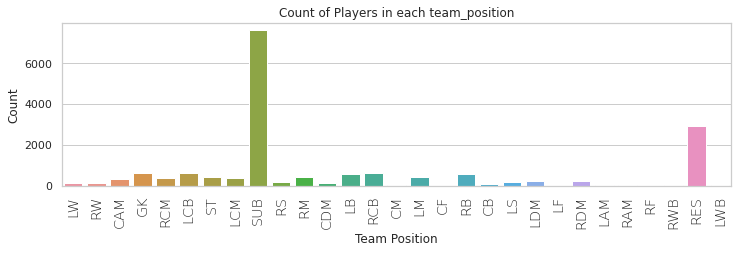

In [18]:
plt.figure(figsize=(12,3))
cplot= sns.countplot(x='team_position', data=df_raw)
cplot.set_xlabel('Team Position')
cplot.set_ylabel('Count')
cplot.set_title('Count of Players in each team_position')

cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=90,
                      horizontalalignment='center',
                      fontweight='light',
                      fontsize='large');
plt.show()



In [19]:
team_position_counts = df_raw[['team_position']].value_counts().to_frame('all_count')
team_position_counts['all_pct'] = team_position_counts['all_count'] / len(df_raw) * 100
team_position_counts

all_count    all_pct
team_position                      
SUB                 7593  43.272354
RES                 2928  16.686613
GK                   642   3.658745
LCB                  638   3.635949
RCB                  638   3.635949
LB                   558   3.180031
RB                   555   3.162934
ST                   445   2.536046
LM                   435   2.479056
RM                   434   2.473357
RCM                  387   2.205505
LCM                  384   2.188408
CAM                  318   1.812276
LDM                  247   1.407648
RDM                  246   1.401949
RS                   191   1.088505
LS                   190   1.082806
CDM                  144   0.820653
LW                   143   0.814954
RW                   142   0.809255
CB                    83   0.473015
CM                    62   0.353337
RWB                   37   0.210862
LWB                   36   0.205163
RAM                   19   0.108281
LAM                   19   0.108281
CF                    13   0.074087
LF                    10   0.056990
RF                    10   0.056990

In [20]:
print(f"SUB and RES team positions take {team_position_counts.loc['SUB', 'all_pct'][0] + team_position_counts.loc['RES', 'all_pct'][0]:0.2f}%") 

df_raw[ (df_raw['team_position'] != 'SUB') & (df_raw['team_position'] != 'RES') ].shape


SUB and RES team positions take 59.96%


(7026, 104)

In [21]:
df_raw.shape

(17547, 104)

Almost 60% of the team postition are subsitue or reserved, Let's see if player_positions can be mapped to a common

In [22]:
df_raw[ (df_raw['team_position'] == 'SUB')][['player_positions', 'team_position']]

player_positions team_position
17         CAM, CM, LW           SUB
30         CAM, CM, RM           SUB
32                  GK           SUB
50              CF, ST           SUB
55                  GK           SUB
...                ...           ...
17763          CM, CDM           SUB
17764               CM           SUB
17765          CM, CDM           SUB
17768               RB           SUB
17769               CM           SUB

[7593 rows x 2 columns]

Find all the unique positions in the **player_positions** column and compare to the unique positions in the **team_position** column.

In [23]:
unique_player_positions = set()
for items in df_raw['player_positions'].iteritems():
    for item in split_ignore_nan(items[1]):
        unique_player_positions.add(item.strip())
        
        
print(f"Number of unique player positions: ", len(unique_player_positions))
print(unique_player_positions)

unique_team_positions = df_raw['team_position'].unique()
unique_team_positions = set(unique_team_positions)
        
print(f"Number of unique team positions: ", len(unique_team_positions))
print(unique_team_positions)

Number of unique player positions:  15
{'CF', 'CAM', 'RM', 'RW', 'LWB', 'CDM', 'LM', 'LB', 'GK', 'RB', 'CB', 'ST', 'LW', 'CM', 'RWB'}
Number of unique team positions:  29
{'SUB', 'RM', 'LWB', 'LDM', 'RCB', 'LCB', 'RAM', 'LCM', 'LS', 'GK', 'ST', 'LF', 'RS', 'CDM', 'RES', 'RB', 'CM', 'CF', 'LAM', 'RF', 'CAM', 'RW', 'RCM', 'LM', 'RDM', 'LB', 'CB', 'LW', 'RWB'}


In [24]:
print("Those position in team_position and not in player_positions: \n", unique_team_positions - unique_player_positions)

Those position in team_position and not in player_positions: 
 {'LCB', 'LF', 'RAM', 'LAM', 'RF', 'SUB', 'RS', 'RCM', 'RDM', 'LCM', 'LS', 'LDM', 'RES', 'RCB'}


In [25]:
print("Those position in player_positions and not in team_position: \n",unique_player_positions - unique_team_positions)

Those position in player_positions and not in team_position: 
 set()


In [26]:
print(f"NaN nation_position samples:\n{df_raw['nation_position'].isna().sum()}")

NaN nation_position samples:
16666


##  Positional Rating Analysis <a class="anchor" id="Positional-Rating-Analysis"></a>

[▲ Return to contents](#Contents)

See how the variables related to each other. From the summary stats, to the correlation and pairwise plot we see strong correlation between each position and its peer or mirror oposite. For example Left winger (lw) are identical to Right winger (rw) ratings. Left Forward (lf), Center Forward (cf), and Right Forward (rf) are also equal. Etc...

Most dominate team positions are SUB and RES.


In [27]:
# Evaluate rating columns and update them from string to an int
for col in REAL_OVERALL_RATING_COLS:
    df_raw[col]= df_raw[col].apply( eval_rating)


In [28]:
df_raw[REAL_OVERALL_RATING_COLS].dtypes

ls     int64
st     int64
rs     int64
lw     int64
lf     int64
cf     int64
rf     int64
rw     int64
lam    int64
cam    int64
ram    int64
lm     int64
lcm    int64
cm     int64
rcm    int64
rm     int64
lwb    int64
ldm    int64
cdm    int64
rdm    int64
rwb    int64
lb     int64
lcb    int64
cb     int64
rcb    int64
rb     int64
dtype: object

In [29]:
df_raw[REAL_OVERALL_RATING_COLS].describe()

ls            st            rs            lw            lf  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean      53.115176     53.115176     53.115176     54.183564     53.901408   
std       20.716520     20.716520     20.716520     21.360859     21.256109   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       50.000000     50.000000     50.000000     51.000000     50.000000   
50%       59.000000     59.000000     59.000000     61.000000     60.000000   
75%       66.000000     66.000000     66.000000     67.000000     67.000000   
max       94.000000     94.000000     94.000000     94.000000     95.000000   

                 cf            rf            rw           lam           cam  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean      53.901408     53.901408     54.183564     54.136092     54.136092   
std       21.256109     21.256109     21.360859     21.303200     21.303200   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       50.000000     50.000000     51.000000     51.000000     51.000000   
50%       60.000000     60.000000     61.000000     60.000000     60.000000   
75%       67.000000     67.000000     67.000000     67.000000     67.000000   
max       95.000000     95.000000     94.000000     95.000000     95.000000   

                ram            lm           lcm            cm           rcm  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean      54.136092     54.787998     53.441899     53.441899     53.441899   
std       21.303200     21.302457     20.702164     20.702164     20.702164   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       51.000000     52.000000     51.000000     51.000000     51.000000   
50%       60.000000     61.000000     59.000000     59.000000     59.000000   
75%       67.000000     67.000000     65.000000     65.000000     65.000000   
max       95.000000     92.000000     91.000000     91.000000     91.000000   

                 rm           lwb           ldm           cdm           rdm  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean      54.787998     52.792101     52.183108     52.183108     52.183108   
std       21.302457     20.545906     20.812211     20.812211     20.812211   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       52.000000     50.000000     48.000000     48.000000     48.000000   
50%       61.000000     58.000000     58.000000     58.000000     58.000000   
75%       67.000000     65.000000     65.000000     65.000000     65.000000   
max       92.000000     89.000000     90.000000     90.000000     90.000000   

                rwb            lb           lcb            cb           rcb  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean      52.792101     52.163675     51.118254     51.118254     51.118254   
std       20.545906     20.565598     21.226919     21.226919     21.226919   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       50.000000     48.000000     44.000000     44.000000     44.000000   
50%       58.000000     58.000000     57.000000     57.000000     57.000000   
75%       65.000000     65.000000     66.000000     66.000000     66.000000   
max       89.000000     88.000000     90.000000     90.000000     90.000000   

                 rb  
count  17547.000000  
mean      52.163675  
std       20.565598  
min        0.000000  
25%       48.000000  
50%       58.000000  
75%       65.000000  
max       88.000000

In [30]:
df_raw[REAL_OVERALL_RATING_COLS].corr()

ls        st        rs        lw        lf        cf        rf  \
ls   1.000000  1.000000  1.000000  0.986799  0.993957  0.993957  0.993957   
st   1.000000  1.000000  1.000000  0.986799  0.993957  0.993957  0.993957   
rs   1.000000  1.000000  1.000000  0.986799  0.993957  0.993957  0.993957   
lw   0.986799  0.986799  0.986799  1.000000  0.997425  0.997425  0.997425   
lf   0.993957  0.993957  0.993957  0.997425  1.000000  1.000000  1.000000   
cf   0.993957  0.993957  0.993957  0.997425  1.000000  1.000000  1.000000   
rf   0.993957  0.993957  0.993957  0.997425  1.000000  1.000000  1.000000   
rw   0.986799  0.986799  0.986799  1.000000  0.997425  0.997425  0.997425   
lam  0.986893  0.986893  0.986893  0.996927  0.997437  0.997437  0.997437   
cam  0.986893  0.986893  0.986893  0.996927  0.997437  0.997437  0.997437   
ram  0.986893  0.986893  0.986893  0.996927  0.997437  0.997437  0.997437   
lm   0.982886  0.982886  0.982886  0.997487  0.994077  0.994077  0.994077   
lcm  0.962697  0.962697  0.962697  0.971651  0.972001  0.972001  0.972001   
cm   0.962697  0.962697  0.962697  0.971651  0.972001  0.972001  0.972001   
rcm  0.962697  0.962697  0.962697  0.971651  0.972001  0.972001  0.972001   
rm   0.982886  0.982886  0.982886  0.997487  0.994077  0.994077  0.994077   
lwb  0.869587  0.869587  0.869587  0.882747  0.875151  0.875151  0.875151   
ldm  0.836718  0.836718  0.836718  0.839446  0.837532  0.837532  0.837532   
cdm  0.836718  0.836718  0.836718  0.839446  0.837532  0.837532  0.837532   
rdm  0.836718  0.836718  0.836718  0.839446  0.837532  0.837532  0.837532   
rwb  0.869587  0.869587  0.869587  0.882747  0.875151  0.875151  0.875151   
lb   0.835170  0.835170  0.835170  0.843846  0.836987  0.836987  0.836987   
lcb  0.753074  0.753074  0.753074  0.741622  0.741560  0.741560  0.741560   
cb   0.753074  0.753074  0.753074  0.741622  0.741560  0.741560  0.741560   
rcb  0.753074  0.753074  0.753074  0.741622  0.741560  0.741560  0.741560   
rb   0.835170  0.835170  0.835170  0.843846  0.836987  0.836987  0.836987   

           rw       lam       cam       ram        lm       lcm        cm  \
ls   0.986799  0.986893  0.986893  0.986893  0.982886  0.962697  0.962697   
st   0.986799  0.986893  0.986893  0.986893  0.982886  0.962697  0.962697   
rs   0.986799  0.986893  0.986893  0.986893  0.982886  0.962697  0.962697   
lw   1.000000  0.996927  0.996927  0.996927  0.997487  0.971651  0.971651   
lf   0.997425  0.997437  0.997437  0.997437  0.994077  0.972001  0.972001   
cf   0.997425  0.997437  0.997437  0.997437  0.994077  0.972001  0.972001   
rf   0.997425  0.997437  0.997437  0.997437  0.994077  0.972001  0.972001   
rw   1.000000  0.996927  0.996927  0.996927  0.997487  0.971651  0.971651   
lam  0.996927  1.000000  1.000000  1.000000  0.996654  0.982360  0.982360   
cam  0.996927  1.000000  1.000000  1.000000  0.996654  0.982360  0.982360   
ram  0.996927  1.000000  1.000000  1.000000  0.996654  0.982360  0.982360   
lm   0.997487  0.996654  0.996654  0.996654  1.000000  0.982998  0.982998   
lcm  0.971651  0.982360  0.982360  0.982360  0.982998  1.000000  1.000000   
cm   0.971651  0.982360  0.982360  0.982360  0.982998  1.000000  1.000000   
rcm  0.971651  0.982360  0.982360  0.982360  0.982998  1.000000  1.000000   
rm   0.997487  0.996654  0.996654  0.996654  1.000000  0.982998  0.982998   
lwb  0.882747  0.891267  0.891267  0.891267  0.909320  0.951194  0.951194   
ldm  0.839446  0.857213  0.857213  0.857213  0.870188  0.934330  0.934330   
cdm  0.839446  0.857213  0.857213  0.857213  0.870188  0.934330  0.934330   
rdm  0.839446  0.857213  0.857213  0.857213  0.870188  0.934330  0.934330   
rwb  0.882747  0.891267  0.891267  0.891267  0.909320  0.951194  0.951194   
lb   0.843846  0.854188  0.854188  0.854188  0.873990  0.926009  0.926009   
lcb  0.741622  0.759717  0.759717  0.759717  0.777863  0.856399  0.856399   
cb   0.741622  0.759717  0.759717  0.759717  0.777863  0.856399  0.856399   
rcb  0

Mapping of correlated columns skills column to Player Positions
<pre>
-    'ls', 'st', 'rs',     ==> ST           # Striker
-    'lf', 'cf', 'rf',     ==> CF           # Center forward
-    'lw',                 ==> LW           # Left winger (typically more attack-minded than a left midfielder)
-    'rw',                 ==> RW           # Right winger (a more attacking option than a right midfielder)
-    'lam', 'cam', 'ram',  ==> CAM          # Central attacking midfielder
-    'lm'                  ==> LM           # Left midfielder
-    'lcm', 'cm', 'rcm',   ==> CM           # Centre midfielder
-    'rm',                 ==> RM           # Right midfielder
-    'lwb'                 ==> LWB          #
-    'ldm','cdm','rdm',    ==> CDM          # Central defensive midfielder
-    'rwb',                ==> RWB          # 
-    'lb'                  ==> LB           # Left back
-    'lcb','cb','rcb',     ==> CB           # Centre back
-    'rb',                 ==> RB           # Right back
-                          ==> GK           # Goalkeeper
</pre>



In [31]:
position_rating_map = {
    'rating_striker': 'st',
    'rating_wing_left': 'lw',
    'rating_forward_center': 'cf',
    'rating_wing_right': 'rw',
    'rating_attacking_midfielder_center': 'cam',
    'rating_midfielder_left': 'lm',
    'rating_midfielder_center': 'cm',
    'rating_midfielder_right': 'rm',
    'rating_back_wing_left': 'lwb',
    'rating_central_def_midfielder': 'cdm',
    'rating_back_wing_right': 'rwb',
    'rating_back_left': 'lb',
    'rating_back_center': 'cb',
    'rating_back_right': 'rb'
}

for k, r in position_rating_map.items():
    print(f"{r:5} mapped to {k}")
    df_raw[k] = df_raw[r]


st    mapped to rating_striker
lw    mapped to rating_wing_left
cf    mapped to rating_forward_center
rw    mapped to rating_wing_right
cam   mapped to rating_attacking_midfielder_center
lm    mapped to rating_midfielder_left
cm    mapped to rating_midfielder_center
rm    mapped to rating_midfielder_right
lwb   mapped to rating_back_wing_left
cdm   mapped to rating_central_def_midfielder
rwb   mapped to rating_back_wing_right
lb    mapped to rating_back_left
cb    mapped to rating_back_center
rb    mapped to rating_back_right


In [32]:
position_ratings = [ r for r in position_rating_map.keys()] 
df_raw[position_ratings + ['team_position']]

rating_striker  rating_wing_left  rating_forward_center  \
0                  94                92                     93   
1                  90                94                     95   
2                  87                92                     92   
3                   0                 0                      0   
4                  85                90                     90   
...               ...               ...                    ...   
17765              42                44                     44   
17766              47                50                     48   
17767              47                50                     49   
17768              48                49                     48   
17769              45                46                     46   

       rating_wing_right  rating_attacking_midfielder_center  \
0                     92                                  91   
1                     94                                  95   
2                     92                                  92   
3                      0                                   0   
4                     90                                  91   
...                  ...                                 ...   
17765                 44                                  46   
17766                 50                                  48   
17767                 50                                  50   
17768                 49                                  47   
17769                 46                                  47   

       rating_midfielder_left  rating_midfielder_center  \
0                          91                        84   
1                          92                        86   
2                          91                        84   
3                           0                         0   
4                          91                        90   
...                       ...                       ...   
17765                      45                        48   
17766                      49                        42   
17767                      51                        48   
17768                      48                        43   
17769                      47                        47   

       rating_midfielder_right  rating_back_wing_left  \
0                           91                     68   
1                           92                     65   
2                           91                     68   
3                            0                      0   
4                           91                     80   
...                        ...                    ...   
17765                       45                     48   
17766                       49                     40   
17767                       51                     51   
17768                       48                     48   
17769                       47                     47   

       rating_central_def_midfielder  rating_back_wing_right  \
0                                 64                      68   
1                                 63                      65   
2                                 63                      68   
3                                  0                       0   
4                                 80                      80   
...                              ...                     ...   
17765                             50                      48   
17766                             36                      40   
17767                             48                      51   
17768                             43                      48   
17769                             48                      47   

       rating_back_left  rating_back_center  rating_back_right team_position  
0                    64                  56                 64            LW  
1                    60                  49                 60            RW  
2                    63                  50  

/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


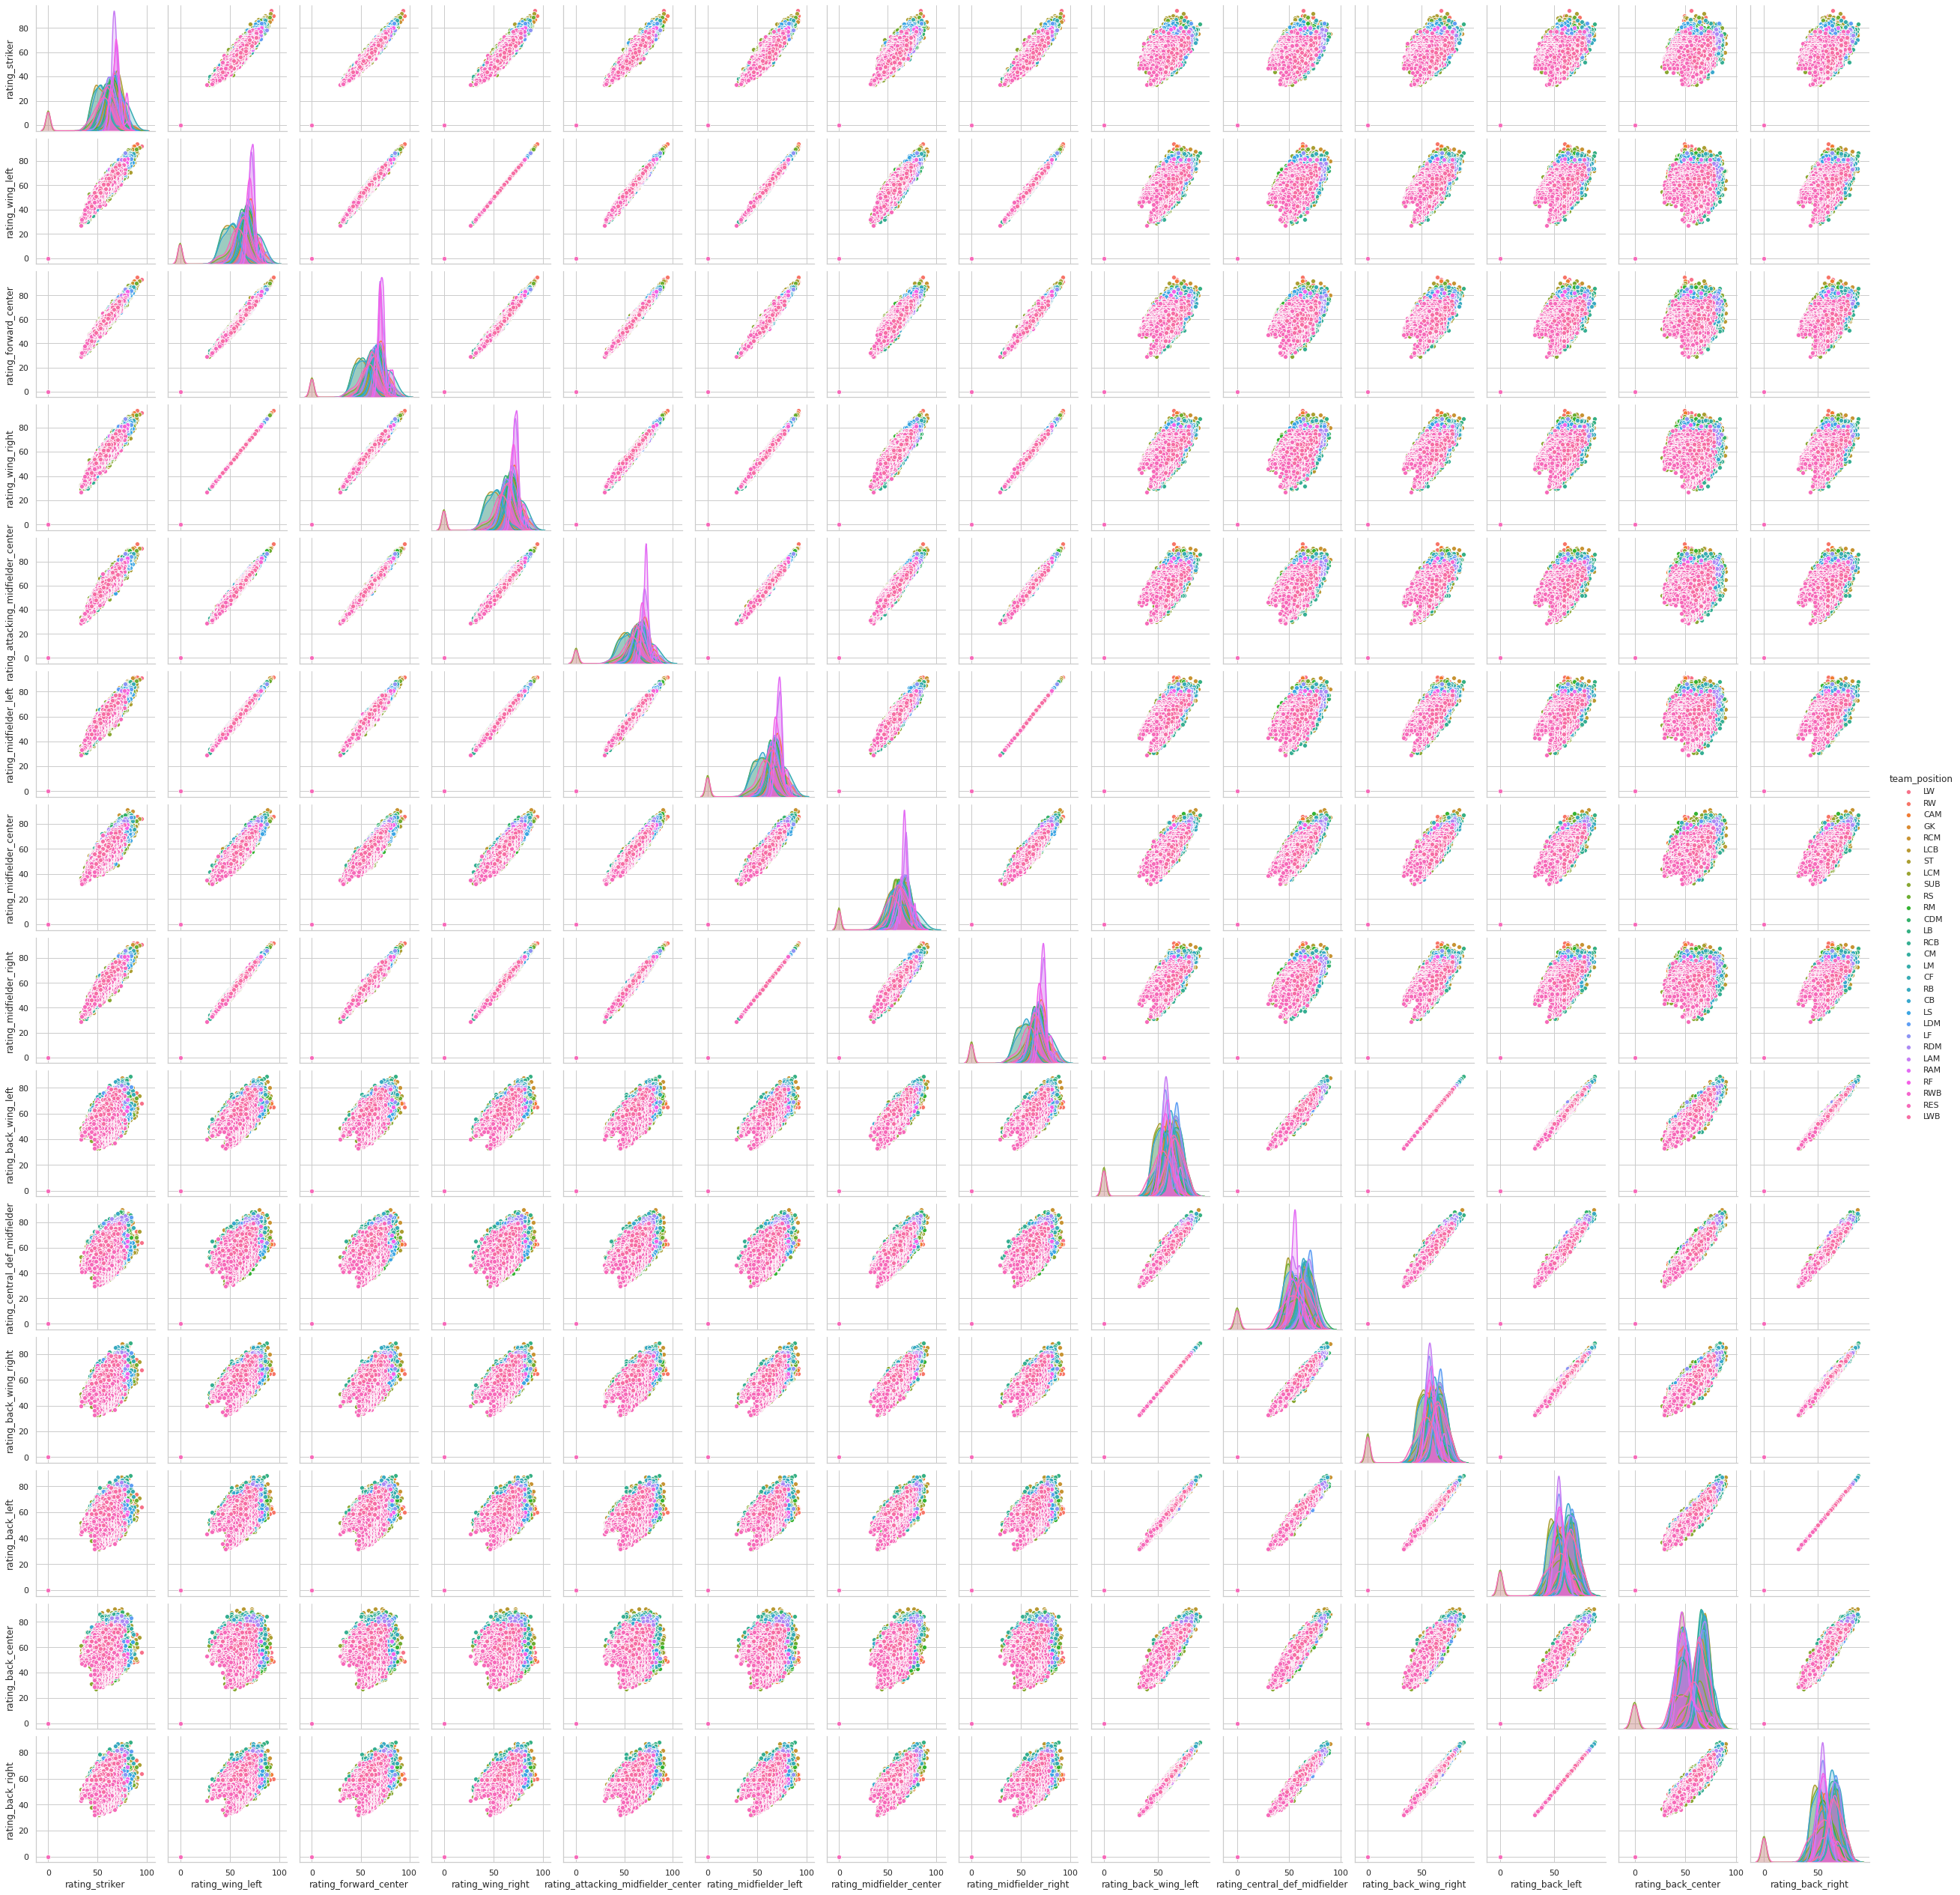

In [33]:
position_cols = [ r for r in position_rating_map.keys()] + ['team_position']
sns.pairplot(df_raw[position_cols], hue='team_position');

### Generalize player positions <a class="anchor" id="Generalize-player-positions"></a>
[▲ Return to contents](#Contents)


In [34]:
# Update the team position to match the reduced positions in the player position column        

def generalize_position(p) -> str:   

    position_mapping = {}
    position_mapping.update({ pos:'ST' for pos in [ 'LS', 'ST', 'RS']})
    position_mapping.update({ 'LW':'LW'})
    position_mapping.update({ 'RW':'RW'})
    position_mapping.update({ pos:'CF' for pos in [ 'LF', 'CF', 'RF']})
    position_mapping.update({ pos:'CAM' for pos in [ 'LAM', 'CAM', 'RAM']})
    position_mapping.update({ pos:'CM' for pos in [  'LCM', 'CM', 'RCM']})
    position_mapping.update({ 'LM':'LM'})
    position_mapping.update({ 'RM':'RM'})    
    position_mapping.update({ pos:'CDM' for pos in [ 'LDM', 'CDM', 'RDM']})
    position_mapping.update({ 'LWB':'LWB'})
    position_mapping.update({ 'RWB':'RWB'}) 
    position_mapping.update({ pos:'CB' for pos in [ 'LCB', 'CB', 'RCB']})
    position_mapping.update({ 'LB':'LB'})
    position_mapping.update({ 'RB':'RB'}) 
    position_mapping.update({ 'GK':'GK'})
    position_mapping.update({ 'SUB':'SUB'})
    position_mapping.update({ 'RES':'RES'})

    if p == np.nan:
        return 'RES'
    elif ( isinstance(p, float)) and math.isnan(p):
        return 'RES'
    else:
        return position_mapping[p]
    


In [35]:
df_raw['team_position_general'] = df_raw['team_position'].apply( generalize_position)

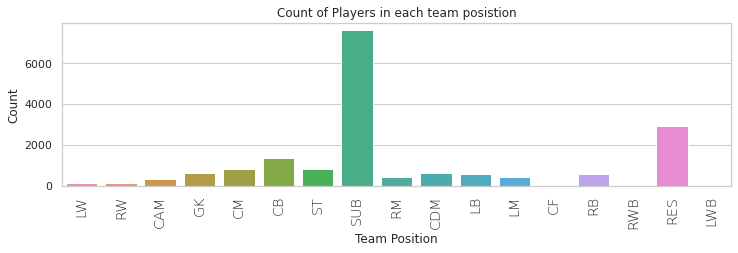

In [36]:
plt.figure(figsize=(12,3))
cplot= sns.countplot(x='team_position_general', data=df_raw)
cplot.set_xlabel('Team Position')
cplot.set_ylabel('Count')
cplot.set_title('Count of Players in each team posistion')

cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=90,
                      horizontalalignment='center',
                      fontweight='light',
                      fontsize='large');
plt.show()


/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/saad/anaconda3/envs/cs109a/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


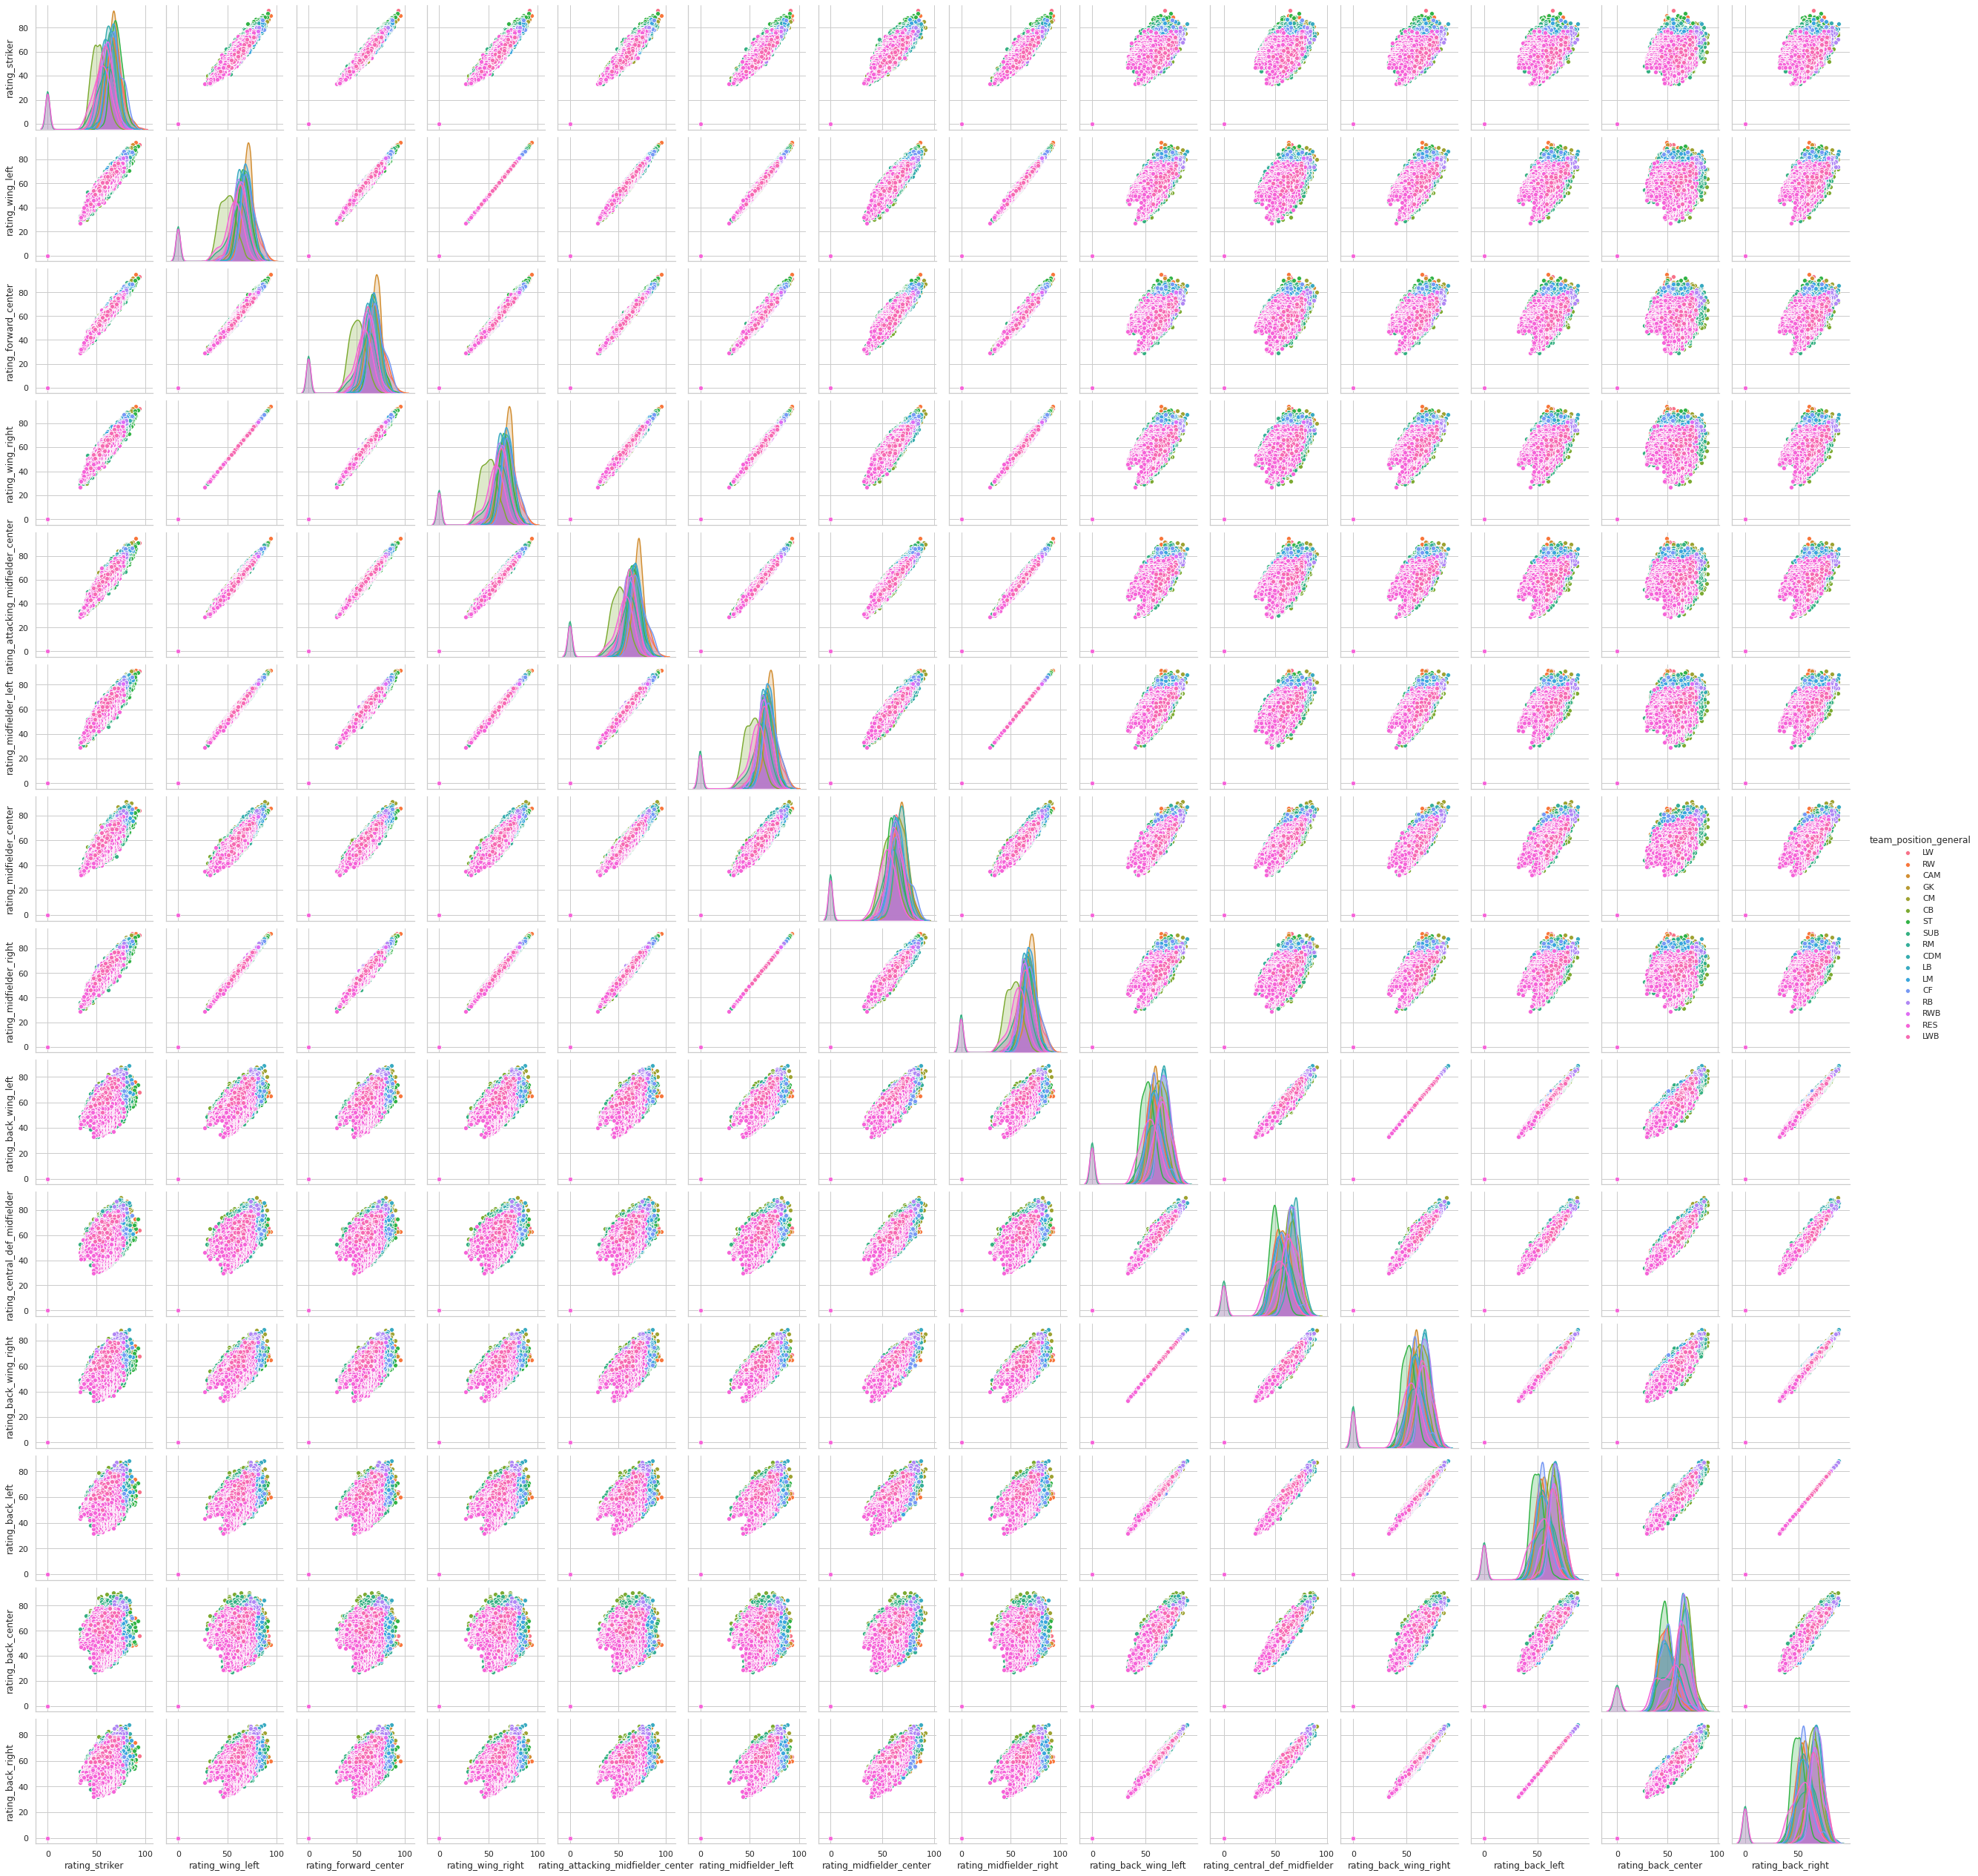

In [37]:
position_cols = [ r for r in position_rating_map.keys()] + ['team_position_general']
sns.pairplot(df_raw[position_cols], hue='team_position_general');

In [38]:
le = LabelEncoder()

df_raw['team_position'] = le.fit_transform(df_raw['team_position'])

team_position_encoding = le.classes_
team_position_encoding

array(['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LAM', 'LB', 'LCB', 'LCM',
       'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM',
       'RDM', 'RES', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST', 'SUB'],
      dtype=object)

### Skills GoalKeeping  <a class="anchor" id="Skills-GoalKeeping"></a>
[▲ Return to contents](#Contents)


In [39]:
df_raw[GK_SKILLS_COLS].head()

gk_diving  gk_handling  gk_kicking  gk_reflexes  gk_speed  gk_positioning
0        NaN          NaN         NaN          NaN       NaN             NaN
1        NaN          NaN         NaN          NaN       NaN             NaN
2        NaN          NaN         NaN          NaN       NaN             NaN
3       90.0         85.0        87.0         94.0      58.0            88.0
4        NaN          NaN         NaN          NaN       NaN             NaN

In [40]:
df_raw[GK_SKILLS_COLS].describe()

gk_diving  gk_handling   gk_kicking  gk_reflexes     gk_speed  \
count  1954.000000  1954.000000  1954.000000  1954.000000  1954.000000   
mean     65.340839    62.906858    61.473388    66.109007    38.622313   
std       7.832508     7.577118     7.690343     8.251481    10.432954   
min      45.000000    43.000000    35.000000    44.000000    12.000000   
25%      60.000000    58.000000    56.000000    60.000000    30.000000   
50%      65.000000    63.000000    61.000000    66.000000    40.000000   
75%      70.000000    68.000000    66.000000    72.000000    46.000000   
max      91.000000    92.000000    91.000000    94.000000    65.000000   

       gk_positioning  
count     1954.000000  
mean        63.024053  
std          8.689674  
min         38.000000  
25%         57.000000  
50%         63.000000  
75%         69.000000  
max         90.000000

In [41]:
print(f"NaN GK_SKILLS_COLS samples:\n{df_raw[GK_SKILLS_COLS].isna().sum()}")

NaN GK_SKILLS_COLS samples:
gk_diving         15593
gk_handling       15593
gk_kicking        15593
gk_reflexes       15593
gk_speed          15593
gk_positioning    15593
dtype: int64


In [42]:
# Set all GK skills NaN to zero
df_raw[GK_SKILLS_COLS] = df_raw[GK_SKILLS_COLS].apply( lambda x: x.fillna(0))


In [43]:
df_raw[GK_SKILLS_COLS].describe()

gk_diving   gk_handling    gk_kicking   gk_reflexes      gk_speed  \
count  17547.000000  17547.000000  17547.000000  17547.000000  17547.000000   
mean       7.276230      7.005186      6.845558      7.361771      4.300906   
std       20.720618     19.950298     19.508002     20.978249     12.638710   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       91.000000     92.000000     91.000000     94.000000     65.000000   

       gk_positioning  
count    17547.000000  
mean         7.018237  
std         20.037199  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max         90.000000

### Body Type  <a class="anchor" id="body_type"></a>
[▲ Return to contents](#Contents)

There are essentially 3 basic body types, Lean, Normal, Stocky and six custom body types for specific players. It is not clear if this was purposeful or in error. To clean these custom types they will be replaced with the dominate majority - Normal.

In [44]:
df_raw['body_type'].value_counts()

Normal                 10260
Lean                    6215
Stocky                  1065
Neymar                     1
Akinfenwa                  1
PLAYER_BODY_TYPE_25        1
Messi                      1
Courtois                   1
Shaqiri                    1
C. Ronaldo                 1
Name: body_type, dtype: int64

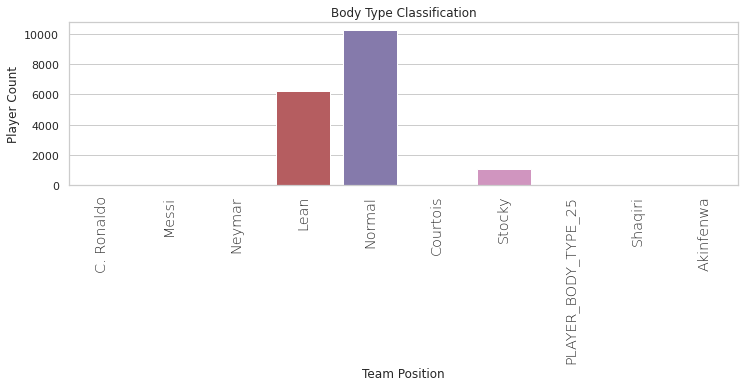

In [45]:
plt.figure(figsize=(12,3))
cplot= sns.countplot(x='body_type', data=df_raw)
cplot.set_xlabel('Team Position')
cplot.set_ylabel('Player Count')
cplot.set_title('Body Type Classification')

cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=90,
                      horizontalalignment='center',
                      fontweight='light',
                      fontsize='large');
plt.show()

In [46]:
# df_raw[ ~df_raw['body_type'].isin(['Normal', 'Lean', 'Stocky']) ][['short_name', 'body_type']]

In [47]:
# Convert those few specialized body types to the commone three.

df_raw[ ~df_raw['body_type'].isin(['Normal', 'Lean', 'Stocky']) ] = 'Normal'

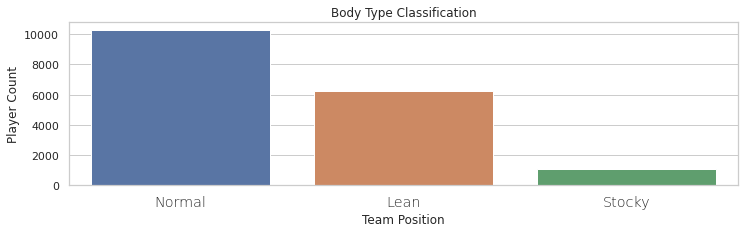

In [48]:
plt.figure(figsize=(12,3))
cplot= sns.countplot(x='body_type', data=df_raw)
cplot.set_xlabel('Team Position')
cplot.set_ylabel('Player Count')
cplot.set_title('Body Type Classification')

cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=0,
                      horizontalalignment='center',
                      fontweight='light',
                      fontsize='large');
plt.show()

### work_rate <a class="anchor" id="work_rate"></a>
[▲ Return to contents](#Contents)

Categorical consisting of 10 possible values. They will be encoded as an ordinal.

In [49]:
df_raw['work_rate'].value_counts()

Medium/Medium    9503
High/Medium      3107
Medium/High      1600
High/High         970
Medium/Low        805
High/Low          672
Low/Medium        433
Low/High          420
Low/Low            30
Normal              7
Name: work_rate, dtype: int64

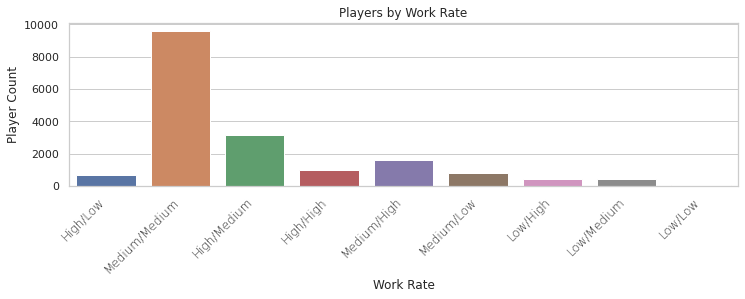

In [75]:
plt.figure(figsize=(12,3))
cplot= sns.countplot(x='work_rate', data=df_raw)
cplot.set_xlabel('Work Rate')
cplot.set_ylabel('Player Count')
cplot.set_title('Players by Work Rate')

cplot.set_xticklabels(cplot.get_xticklabels(),
                      rotation=45,
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');
plt.show()

In [51]:

work_rate_cat = [
    "Low/Low",
    "Low/Medium",
    "Low/High",
    "Medium/Low",
    "Medium/Medium",
    "Normal",
    "Medium/High",     
    "High/Low",
    "High/Medium",      
    "High/High"        
]

enc = OrdinalEncoder(categories={ 0: work_rate_cat})


df_raw['work_rate_ordinal'] = enc.fit_transform(df_raw[['work_rate']] )

In [52]:
df_raw[['work_rate', 'work_rate_ordinal']].head(10)

work_rate  work_rate_ordinal
0         Normal                5.0
1         Normal                5.0
2         Normal                5.0
3  Medium/Medium                4.0
4      High/High                9.0
5    High/Medium                8.0
6    High/Medium                8.0
7      High/High                9.0
8    High/Medium                8.0
9  Medium/Medium                4.0

### player_traits <a class="anchor" id="player_traits"></a>
[▲ Return to contents](#Contents)

In [53]:
df_raw['player_traits'].head(10)

0                                               Normal
1                                               Normal
2                                               Normal
3                       GK Long Throw, Saves with Feet
4    Leadership, Early Crosser, Long Passer (CPU AI...
5    Dives Into Tackles (CPU AI Only), Leadership, ...
6    Diver, Beat Offside Trap, Outside Foot Shot, T...
7    Leadership, Long Shot Taker (CPU AI Only), Pla...
8    Beat Offside Trap, Finesse Shot, Flair, Playma...
9            Puncher, GK Long Throw, Comes For Crosses
Name: player_traits, dtype: object

In [74]:
player_traits = defaultdict(int)
for items in df_raw['player_traits'].iteritems():
    for item in split_ignore_nan(items[1]):
        player_traits[item.strip()] += 1
        
        
print(f"Number of unique player traits: ", len(player_traits))
player_traits

Number of unique player traits:  37


defaultdict(int,
            {'Power Free-Kick': 218,
             'Diver': 191,
             'Flair': 1012,
             'Long Shot Taker (CPU AI Only)': 1131,
             'Speed Dribbler (CPU AI Only)': 1100,
             'Through Ball': 51,
             'Finesse Shot': 430,
             'Playmaker (CPU AI Only)': 676,
             'One Club Player': 1,
             'Chip Shot (CPU AI Only)': 89,
             'Selfish': 378,
             'Technical Dribbler (CPU AI Only)': 1253,
             'Takes Finesse Free Kicks': 411,
             'GK Long Throw': 143,
             'Saves with Feet': 68,
             'Leadership': 508,
             'Early Crosser': 394,
             'Long Passer (CPU AI Only)': 641,
             'Dives Into Tackles (CPU AI Only)': 642,
             'Power Header': 711,
             'Team Player': 438,
             'Beat Offside Trap': 673,
             'Outside Foot Shot': 76,
             'Puncher': 267,
             'Comes For Crosses': 236,
             '1-

Encode all position in the team_positions column, Save the encoding for later future encoding/decoding 

WARNING, one-hot encoding may not work well for tree based models. 

In [55]:

# One hot encode the player attributes. The new columns are prefixed with 'pt_'
def player_traits_one_hot_encode(df) -> pd.DataFrame:

    # Column cleanup. The column consists of a comma separate string and some NaNs. 
    # Here we will replace the NaN with empty string and treat as no traits. 
    # Next the strings are converted to lists so a one-hot encoder can be run 

    df['player_traits'].fillna("", inplace=True)
    df['player_traits'] = df['player_traits'].apply(split_ignore_nan)

    mlb = MultiLabelBinarizer(sparse_output=True)

    df = df.join(
                pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('player_traits')),
                index=df.index,
                columns=[ "pt_"+c for c in mlb.classes_])    
    )

    # TODO the NaN seem to result in an extract column that is all zeros, deleting it.
    df.drop(['pt_'], axis=1, inplace=True)

    return df


In [56]:

df_new = player_traits_one_hot_encode(df_raw)
df_new


sofifa_id                                         player_url  \
0        Normal                                             Normal   
1        Normal                                             Normal   
2        Normal                                             Normal   
3        193080  https://sofifa.com/player/193080/david-de-gea-...   
4        192985  https://sofifa.com/player/192985/kevin-de-bruy...   
...         ...                                                ...   
17765    238985  https://sofifa.com/player/238985/pierce-philli...   
17766    240160  https://sofifa.com/player/240160/alexander-kal...   
17767    241304  https://sofifa.com/player/241304/junliang-ma/1...   
17768    240158  https://sofifa.com/player/240158/christoph-ehl...   
17769    243961  https://sofifa.com/player/243961/evan-tweed/19...   

         short_name              long_name     age         dob height_cm  \
0            Normal                 Normal  Normal      Normal    Normal   
1            Normal                 Normal  Normal      Normal    Normal   
2            Normal                 Normal  Normal      Normal    Normal   
3            De Gea  David De Gea Quintana      27  1990-11-07       193   
4      K. De Bruyne        Kevin De Bruyne      27  1991-06-28       181   
...             ...                    ...     ...         ...       ...   
17765   P. Phillips        Pierce Phillips      19  1998-09-28       180   
17766    A. Kaltner      Alexander Kaltner      18  1999-10-24       178   
17767   Ma Junliang                    马俊亮      20  1998-03-02       181   
17768     C. Ehlich       Christoph Ehlich      19  1999-02-02       179   
17769      E. Tweed             Evan Tweed      19  1999-03-01       180   

      weight_kg          nationality                club overall potential  \
0        Normal               Normal              Normal  Normal    Normal   
1        Normal               Normal              Normal  Normal    Normal   
2        Normal               Normal              Normal  Normal    Normal   
3            76                Spain   Manchester United      91        93   
4            70              Belgium     Manchester City      91        92   
...         ...                  ...                 ...     ...       ...   
17765        72  Republic of Ireland           Cork City      47        61   
17766        75              Germany  SpVgg Unterhaching      47        61   
17767        64             China PR    Guangzhou R&F FC      47        61   
17768        73              Germany  SpVgg Unterhaching      47        59   
17769        72  Republic of Ireland          Derry City      47        58   

       value_eur wage_eur player_positions preferred_foot  \
0         Normal   Normal           Normal         Normal   
1         Normal   Normal           Normal         Normal   
2         Normal   Normal           Normal         Normal   
3       72000000   260000               GK          Right   
4      102000000   355000          CAM, CM          Right   
...          ...      ...              ...            ...   
17765      60000     1000          CM, CDM          Right   
17766      60000     1000               ST          Right   
17767      60000     1000               CM          Right   
17768      40000     1000               RB          Right   
17769      50000     1000               CM          Right   

      international_reputation weak_foot skill_moves      work_rate body_type  \
0                       Normal    Normal      Normal         Normal    Normal   
1                       Normal    Normal      Normal         Normal    Normal   
2                       Normal    Normal      Normal         Normal    Normal   
3                            4         3           1  Medium/Medium      Lean   
4                            4         5           4      High/High    Normal   
...                        ...       ...         ...            ...       ...   
17765          

In [57]:
df_new.head()

sofifa_id                                         player_url    short_name  \
0    Normal                                             Normal        Normal   
1    Normal                                             Normal        Normal   
2    Normal                                             Normal        Normal   
3    193080  https://sofifa.com/player/193080/david-de-gea-...        De Gea   
4    192985  https://sofifa.com/player/192985/kevin-de-bruy...  K. De Bruyne   

               long_name     age         dob height_cm weight_kg nationality  \
0                 Normal  Normal      Normal    Normal    Normal      Normal   
1                 Normal  Normal      Normal    Normal    Normal      Normal   
2                 Normal  Normal      Normal    Normal    Normal      Normal   
3  David De Gea Quintana      27  1990-11-07       193        76       Spain   
4        Kevin De Bruyne      27  1991-06-28       181        70     Belgium   

                club overall potential  value_eur wage_eur player_positions  \
0             Normal  Normal    Normal     Normal   Normal           Normal   
1             Normal  Normal    Normal     Normal   Normal           Normal   
2             Normal  Normal    Normal     Normal   Normal           Normal   
3  Manchester United      91        93   72000000   260000               GK   
4    Manchester City      91        92  102000000   355000          CAM, CM   

  preferred_foot international_reputation weak_foot skill_moves  \
0         Normal                   Normal    Normal      Normal   
1         Normal                   Normal    Normal      Normal   
2         Normal                   Normal    Normal      Normal   
3          Right                        4         3           1   
4          Right                        4         5           4   

       work_rate body_type real_face release_clause_eur  \
0         Normal    Normal    Normal             Normal   
1         Normal    Normal    Normal             Normal   
2         Normal    Normal    Normal             Normal   
3  Medium/Medium      Lean       Yes          1.386e+08   
4      High/High    Normal       Yes          1.964e+08   

                                         player_tags team_position  \
0                                             Normal        Normal   
1                                             Normal        Normal   
2                                             Normal        Normal   
3                                                NaN             5   
4  #Dribbler, #Playmaker  , #Engine, #Distance Sh...            19   

  team_jersey_number loaned_from      joined contract_valid_until  \
0             Normal      Normal      Normal               Normal   
1             Normal      Normal      Normal               Normal   
2             Normal      Normal      Normal               Normal   
3                  1         NaN  2011-07-01                 2019   
4                 17         NaN  2015-08-30                 2023   

  nation_position nation_jersey_number    pace shooting passing dribbling  \
0          Normal               Normal  Normal   Normal  Normal    Normal   
1          Normal               Normal  Normal   Normal  Normal    Normal   
2          Normal               Normal  Normal   Normal  Normal    Normal   
3              GK                    1     NaN      NaN     NaN       NaN   
4             RCM                    7      77       86      92        87   

  defending  physic gk_diving gk_handling gk_kicking gk_reflexes gk_speed  \
0    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
1    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
2    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
3       NaN     NaN        90          85         87          94       58   
4        60      78         0           0          0           0        0   

  gk_positioning attacking_crossing attacking

In [58]:

df_raw.head()

sofifa_id                                         player_url    short_name  \
0    Normal                                             Normal        Normal   
1    Normal                                             Normal        Normal   
2    Normal                                             Normal        Normal   
3    193080  https://sofifa.com/player/193080/david-de-gea-...        De Gea   
4    192985  https://sofifa.com/player/192985/kevin-de-bruy...  K. De Bruyne   

               long_name     age         dob height_cm weight_kg nationality  \
0                 Normal  Normal      Normal    Normal    Normal      Normal   
1                 Normal  Normal      Normal    Normal    Normal      Normal   
2                 Normal  Normal      Normal    Normal    Normal      Normal   
3  David De Gea Quintana      27  1990-11-07       193        76       Spain   
4        Kevin De Bruyne      27  1991-06-28       181        70     Belgium   

                club overall potential  value_eur wage_eur player_positions  \
0             Normal  Normal    Normal     Normal   Normal           Normal   
1             Normal  Normal    Normal     Normal   Normal           Normal   
2             Normal  Normal    Normal     Normal   Normal           Normal   
3  Manchester United      91        93   72000000   260000               GK   
4    Manchester City      91        92  102000000   355000          CAM, CM   

  preferred_foot international_reputation weak_foot skill_moves  \
0         Normal                   Normal    Normal      Normal   
1         Normal                   Normal    Normal      Normal   
2         Normal                   Normal    Normal      Normal   
3          Right                        4         3           1   
4          Right                        4         5           4   

       work_rate body_type real_face release_clause_eur  \
0         Normal    Normal    Normal             Normal   
1         Normal    Normal    Normal             Normal   
2         Normal    Normal    Normal             Normal   
3  Medium/Medium      Lean       Yes          1.386e+08   
4      High/High    Normal       Yes          1.964e+08   

                                         player_tags team_position  \
0                                             Normal        Normal   
1                                             Normal        Normal   
2                                             Normal        Normal   
3                                                NaN             5   
4  #Dribbler, #Playmaker  , #Engine, #Distance Sh...            19   

  team_jersey_number loaned_from      joined contract_valid_until  \
0             Normal      Normal      Normal               Normal   
1             Normal      Normal      Normal               Normal   
2             Normal      Normal      Normal               Normal   
3                  1         NaN  2011-07-01                 2019   
4                 17         NaN  2015-08-30                 2023   

  nation_position nation_jersey_number    pace shooting passing dribbling  \
0          Normal               Normal  Normal   Normal  Normal    Normal   
1          Normal               Normal  Normal   Normal  Normal    Normal   
2          Normal               Normal  Normal   Normal  Normal    Normal   
3              GK                    1     NaN      NaN     NaN       NaN   
4             RCM                    7      77       86      92        87   

  defending  physic gk_diving gk_handling gk_kicking gk_reflexes gk_speed  \
0    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
1    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
2    Normal  Normal    Normal      Normal     Normal      Normal   Normal   
3       NaN     NaN        90          85         87          94       58   
4        60      78         0           0          0           0        0   

  gk_positioning attacking_crossing attacking

### player_tags  <a class="anchor" id="player_tags"></a>
[▲ Return to contents](#Contents)

In [79]:
df_raw['player_tags']

0        #Speedster, #Dribbler, #Distance Shooter, #Acr...
1        #Dribbler, #Distance Shooter, #FK Specialist, ...
2        #Speedster, #Dribbler, #FK Specialist, #Acroba...
3                                                      NaN
4        #Dribbler, #Playmaker  , #Engine, #Distance Sh...
                               ...                        
17765                                                  NaN
17766                                                  NaN
17767                                                  NaN
17768                                                  NaN
17769                                                  NaN
Name: player_tags, Length: 17770, dtype: object

In [80]:

player_tags = defaultdict(int)
for items in df_raw['player_tags'].iteritems():
    for item in split_ignore_nan(items[1]):
        player_tags[item.strip()] += 1
        
        
print(f"Number of unique player tags: ", len(player_tags))
player_tags

Number of unique player tags:  17


defaultdict(int,
            {'#Speedster': 253,
             '#Dribbler': 109,
             '#Distance Shooter': 28,
             '#Acrobat': 363,
             '#Clinical Finisher': 24,
             '#Complete Forward': 5,
             '#FK Specialist': 25,
             '#Playmaker': 31,
             '#Engine': 234,
             '#Crosser': 35,
             '#Complete Midfielder': 8,
             '#Aerial Threat': 99,
             '#Tackling': 34,
             '#Tactician': 37,
             '#Complete Defender': 6,
             '#Strength': 587,
             '#Poacher': 12})

### preferred_foot  <a class="anchor" id="preferred_foot"></a>
[▲ Return to contents](#Contents)

In [61]:
df_raw['preferred_foot']

0        Normal
1        Normal
2        Normal
3         Right
4         Right
          ...  
17765     Right
17766     Right
17767     Right
17768     Right
17769     Right
Name: preferred_foot, Length: 17547, dtype: object

In [62]:
df_raw['preferred_foot'].isna().sum()

0

In [68]:
df_raw['preferred_foot'].value_counts()

Right    13639
Left      4131
Name: preferred_foot, dtype: int64

# Split the data into train and test

In [63]:
df_raw = pd.read_csv(DATA_DIR_RAW+'players_19.csv')

samples = df_raw.shape[0]

df_raw = df_raw.drop( NOT_TO_BE_USED_COLS + UNNEEDED_FEATURE_COLS, axis=1)
print("Dropping columns: ", NOT_TO_BE_USED_COLS + UNNEEDED_FEATURE_COLS)


train_dataset = df_raw[ ~df_raw['club'].isin(TEST_SET_CLUBS)]
test_dataset = df_raw[ df_raw['club'].isin(TEST_SET_CLUBS)]         

train_samples = train_dataset.shape[0]
test_samples = test_dataset.shape[0]

print(f"Total samples: {samples}")
print(f"Training samples: {train_samples}, {train_samples/samples*100:.2f}%")
print(f"Test samples: {test_samples}, {test_samples/samples*100:.2f}%")

Dropping columns:  ['sofifa_id', 'player_url', 'short_name', 'long_name', 'real_face', 'wage_eur', 'dob', 'nationality', 'nation_jersey_number', 'loaned_from']
Total samples: 17770
Training samples: 17494, 98.45%
Test samples: 276, 1.55%


## Club Analysis <a class="anchor" id="Club"></a>
[▲ Return to contents](#Contents)

Excluding some outliers, the amount of players per club is near a normal distribution with mean near 26 players per club.

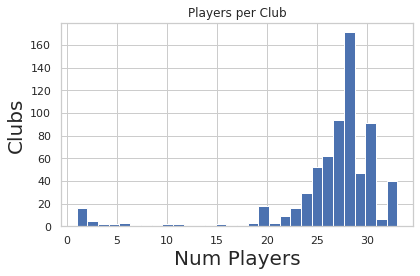

count    679.000000
mean      26.170839
std        5.882350
min        1.000000
25%       26.000000
50%       28.000000
75%       29.000000
max       33.000000
Name: club, dtype: float64

In [64]:
club_player_count = df_raw['club'].value_counts()
    
plt.figure(figsize=[6,4])

plt.hist(club_player_count, bins=30, label='club')

plt.xlabel('Num Players', fontsize=20)
plt.ylabel('Clubs', fontsize = 20)
plt.title('Players per Club')

plt.tight_layout()
plt.show()

club_player_count.describe()

Let's see how the test club player count compare.

In [65]:
for club in TEST_SET_CLUBS:
    cnt = df_raw[ df_raw['club'].isin([club])].shape[0]
    print(f"{club} - {cnt}")

FC Barcelona - 28
FC Bayern München - 28
Real Madrid - 33
Paris Saint-Germain - 30
Juventus - 25
Atlético Madrid - 33
Manchester City - 33
Liverpool - 33
Manchester United - 33


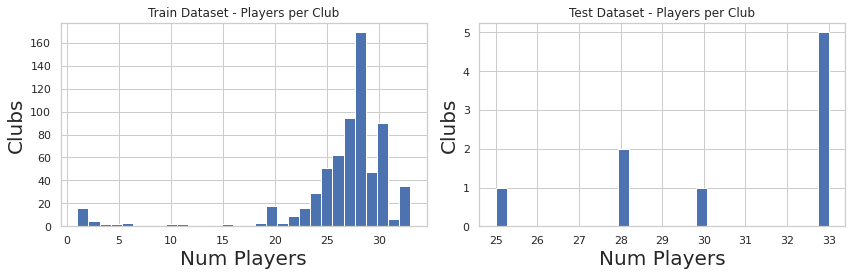

In [66]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(12,4))
ax = axs.ravel()

ax[0].hist( train_dataset['club'].value_counts(), bins=30)
ax[0].set_xlabel('Num Players', fontsize=20)
ax[0].set_ylabel('Clubs', fontsize = 20)
ax[0].set_title('Train Dataset - Players per Club')

ax[1].hist( test_dataset['club'].value_counts(), bins=30)
ax[1].set_xlabel('Num Players', fontsize=20)
ax[1].set_ylabel('Clubs', fontsize = 20)
ax[1].set_title('Test Dataset - Players per Club')

plt.tight_layout()
plt.show()

In [67]:
team_position_counts['train_count'] = train_dataset[['team_position']].value_counts().to_frame('count')
team_position_counts['train_pct'] = team_position_counts['train_count'] / len(df_raw) * 100

team_position_counts['test_count'] = test_dataset[['team_position']].value_counts().to_frame('count')
team_position_counts['test_pct'] = team_position_counts['train_count'] / len(df_raw) * 100

#team_position_counts.reset_index()
team_position_counts

all_count    all_pct  train_count  train_pct  test_count  \
team_position                                                             
SUB                 7593  43.272354         7485  42.121553       108.0   
RES                 2928  16.686613         2859  16.088914        69.0   
GK                   642   3.658745          633   3.562183         9.0   
LCB                  638   3.635949          629   3.539674         9.0   
RCB                  638   3.635949          629   3.539674         9.0   
LB                   558   3.180031          549   3.089477         9.0   
RB                   555   3.162934          546   3.072594         9.0   
ST                   445   2.536046          438   2.464828         7.0   
LM                   435   2.479056          433   2.436691         2.0   
RM                   434   2.473357          432   2.431064         2.0   
RCM                  387   2.205505          378   2.127181         9.0   
LCM                  384   2.188408          375   2.110298         9.0   
CAM                  318   1.812276          317   1.783905         1.0   
LDM                  247   1.407648          247   1.389983         NaN   
RDM                  246   1.401949          246   1.384356         NaN   
RS                   191   1.088505          190   1.069218         1.0   
LS                   190   1.082806          189   1.063590         1.0   
CDM                  144   0.820653          137   0.770962         7.0   
LW                   143   0.814954          136   0.765335         7.0   
RW                   142   0.809255          135   0.759707         7.0   
CB                    83   0.473015           83   0.467079         NaN   
CM                    62   0.353337           62   0.348903         NaN   
RWB                   37   0.210862           37   0.208216         NaN   
LWB                   36   0.205163           36   0.202589         NaN   
RAM                   19   0.108281           19   0.106922         NaN   
LAM                   19   0.108281           19   0.106922         NaN   
CF                    13   0.074087           12   0.067530         1.0   
LF                    10   0.056990           10   0.056275         NaN   
RF                    10   0.056990           10   0.056275         NaN   

                test_pct  
team_position             
SUB            42.121553  
RES            16.088914  
GK              3.562183  
LCB             3.539674  
RCB             3.539674  
LB              3.089477  
RB              3.072594  
ST              2.464828  
LM              2.436691  
RM              2.431064  
RCM             2.127181  
LCM             2.110298  
CAM             1.783905  
LDM             1.389983  
RDM             1.384356  
RS              1.069218  
LS              1.063590  
CDM             0.770962  
LW              0.765335  
RW              0.759707  
CB              0.467079  
CM              0.348903  
RWB             0.208216  
LWB             0.202589  
RAM             0.106922  
LAM             0.106922  
CF              0.067530  
LF              0.056275  
RF              0.056275